In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
from scipy.signal import savgol_filter

In [2]:
# In a base directory, choose (or find two years) and read these data
src = rasterio.open('../subsets/clpx_outcrops/raster/snow_depth/clpx_outcrops_snow_depth_2018.tif')
sd_2018 = src.read(1)
src = rasterio.open('../subsets/clpx_outcrops/raster/snow_depth/clpx_outcrops_snow_depth_2012.tif')
sd_2012 = src.read(1)
src = rasterio.open('../subsets/clpx_outcrops/raster/iqa/2012_v._2018_nrmse_arr.tif')
nrmse = src.read(1)
src = rasterio.open('../subsets/clpx_outcrops/raster/iqa/2012_v._2018_ssim_arr.tif')
ssim = src.read(1)
src = rasterio.open('../subsets/clpx_outcrops/raster/iqa/2012_v._2018_cwssim_arr.tif')
cwssim = src.read(1)
src = rasterio.open('../subsets/clpx_outcrops/raster/iqa/2012_v._2018_gms_arr.tif')
gms = src.read(1)
src = rasterio.open('../subsets/clpx_outcrops/raster/dem/clpx_outcrops_dem.tif')
dem = src.read(1)

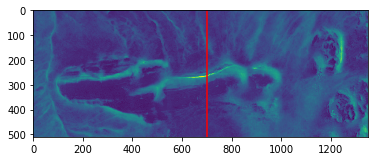

In [3]:
# Choose a profile of an interesting drift to take a look at
# Will need skimage profile to do off normal lines

plt.imshow(sd_2018)
plt.axvline(x=700,c='r')

In [4]:
# Create DataFrame of profiles along above line
# We smooth everything a bit with savitzky golay filter...

ix = pd.Index([i+1 for i in range(len(dem[:,700]))])
df=pd.DataFrame(index=ix)
df['DEM'] = savgol_filter(dem[:,700], 3, 0)
df['Snow Surface 2018'] = savgol_filter(sd_2018[:,700], 3, 1)*5 + df['DEM']
df['Snow Surface 2012'] = savgol_filter(sd_2012[:,700], 3, 1)*5 + df['DEM']
df['Abs. Snow Difference'] = abs(df['Snow Surface 2012'] - df['Snow Surface 2018'])


df['NRMSE'] = savgol_filter(nrmse[:,700], 1, 0)
df['SSIM'] = savgol_filter(ssim[:,700], 1, 0)
df['CW-SSIM'] = savgol_filter(cwssim[:,700], 1, 0)
df['GMS'] = savgol_filter(gms[:,700], 1, 0)

# This is just to flip the profile so that it aligns with the flux direction
df2 = df.iloc[::-1].reset_index(drop=True)

/home/cparr/miniconda3/envs/masters/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


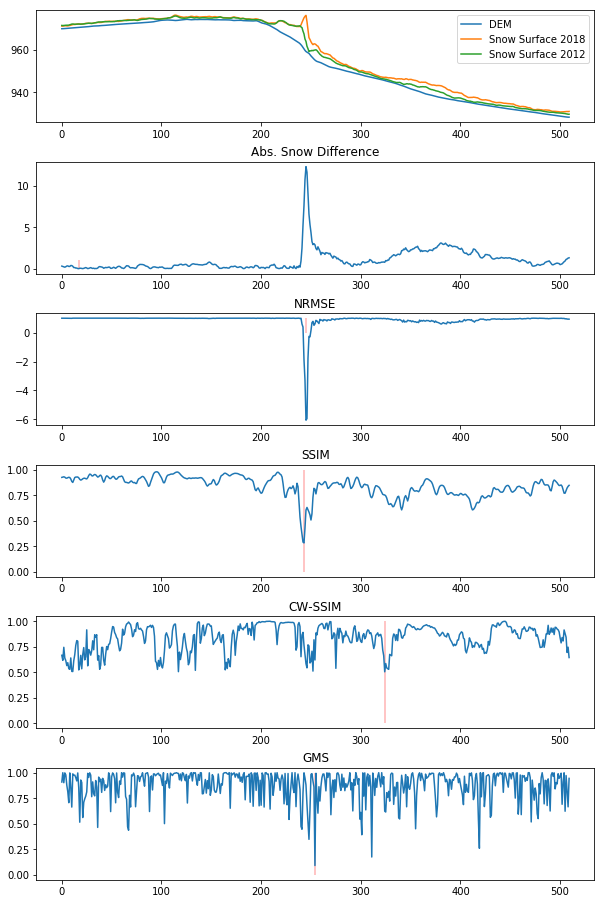

In [11]:
fig, axes = plt.subplots(6, 1, figsize=(10,16))
fig.subplots_adjust(hspace=0.35)

df2.iloc[:, :3].plot(ax=axes[0])

df2.iloc[:, 3].plot(ax=axes[1], title=df2.iloc[:, 3].name)
axes[1].vlines(np.argmin(df2.iloc[:, 3]), 0.0, 1.0, color='r', alpha=0.3)

df2.iloc[:, 4].plot(ax=axes[2], title=df2.iloc[:, 4].name)
axes[2].vlines(np.argmin(df2.iloc[:, 4]), 0.0, 1.0, color='r', alpha=0.3)

df2.iloc[:, 5].plot(ax=axes[3], title=df2.iloc[:, 5].name)
axes[3].vlines(np.argmin(df2.iloc[:, 5]), 0.0, 1.0, color='r', alpha=0.3)

df2.iloc[:, 6].plot(ax=axes[4], title=df2.iloc[:, 6].name)
axes[4].vlines(np.argmin(df2.iloc[:, 6]), 0.0, 1.0,color='r',alpha=0.3)

df2.iloc[:, 7].plot(ax=axes[5], title=df2.iloc[:, 7].name)
axes[5].vlines(np.argmin(df2.iloc[:, 7]), 0.0, 1.0,color='r',alpha=0.3)

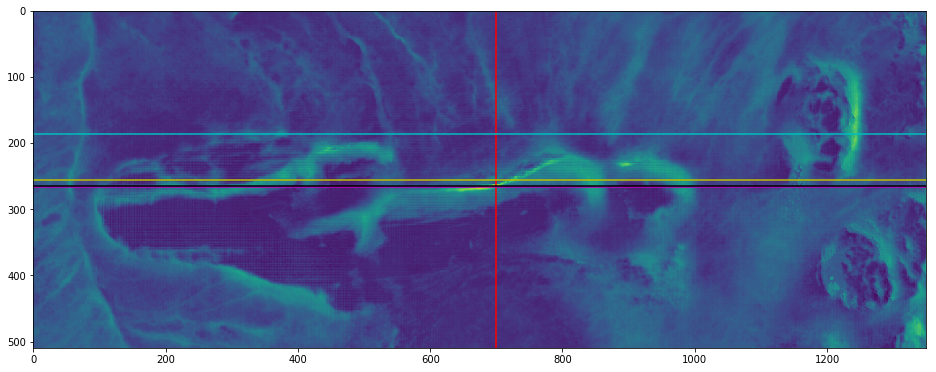

In [12]:
# Show these similarity minima on map
plt.figure(figsize=(16,10))
plt.imshow(sd_2018)
plt.axvline(x=700,c='r')
plt.axhline(y=np.argmin(df.iloc[:, 7]),c='y')
plt.axhline(y=np.argmin(df.iloc[:, 6]),c='c')
plt.axhline(y=np.argmin(df.iloc[:, 5]),c='m')
plt.axhline(y=np.argmin(df.iloc[:, 4]),c='k')

In [86]:
import glob

AttributeError: module 'glob' has no attribute 'fnglob'

In [19]:
import glob
def find_min_indicies(arr, n_elements):
    
    flat_indicies = np.argpartition(arr.ravel(), n_elements - 1)[:n_elements]
    row_indicies, col_indicies = np.unravel_index(flat_indicies, arr.shape)
    return [i for i in zip(col_indicies, row_indicies)]


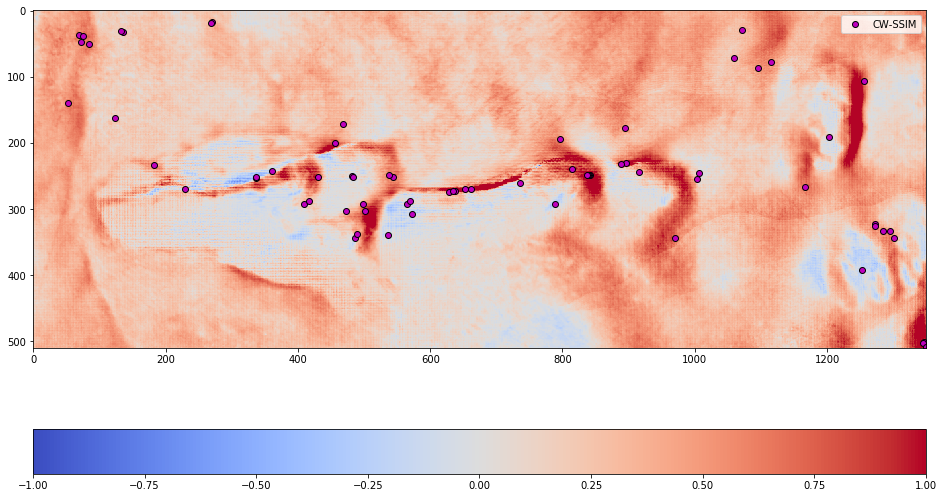

In [109]:
plt.figure(figsize=(16,10))

ax = plt.imshow(sd_2018 - sd_2012, vmin=-1, vmax=1, cmap='coolwarm')

for i in find_min_indicies(cwssim, round(cwssim.size*0.0001)):
    a = ax.axes.plot(i[0], i[1], ".m", markersize=12.0, markeredgecolor='k')

# for i in find_min_indicies(nrmse, 25):
#     b = ax.axes.plot(i[0], i[1], ".c", markersize=12.0, markeredgecolor='k')
    
# for i in find_min_indicies(ssim, 25):
#     c = ax.axes.plot(i[0], i[1], ".y", markersize=12.0, markeredgecolor='k')
    
# for i in find_min_indicies(gms, 50):
#     d = ax.axes.plot(i[0], i[1], ".g", markersize=12.0, markeredgecolor='k')

a[0].set_label('CW-SSIM')
#b[0].set_label('NRMSE')
#c[0].set_label('SSIM')
#d[0].set_label('GMS')
plt.colorbar(orientation='horizontal')
plt.legend()
plt.savefig('../../scratch/sim_minima_test.png', dpi=300, bbox_inches='tight')

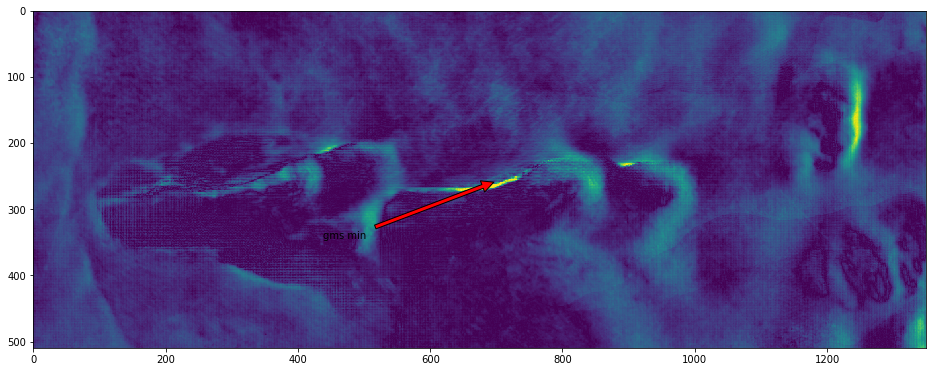

In [310]:
plt.figure(figsize=(16,10))

ax = plt.imshow(abs(sd_2018-sd_2012), vmin=0, vmax=2)
ax.axes.annotate('gms min', xy=ind_frac,  xycoords='axes fraction',
            xytext=ind_frac_text, textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            );


In [313]:
ind = np.unravel_index(np.argmin(ssim, axis=None), gms.shape)
ind_frac = (ind[0]/sd_2018.shape[0], ind[1]/sd_2018.shape[1])
ind_frac_text = (ind_frac[0] - 0.15, ind_frac[1] - 0.15)

In [335]:
find_min_indicies(ssim, 5)

[(537, 248), (1203, 191), (1345, 502), (565, 293), (1256, 106)]

In [95]:
outpath = '../subsets/clpx_outcrops/raster/iqa/'
pname = '2012 v. 2018'
pname = pname.replace(' ', '_')
import os

pname_dir = os.path.join(outpath, pname)

# try:
#     pdir = os.makedirs(os.path.join(outpath, pname))
# except FileExistsError:
#     # directory already exists
#     pass

#pdir

In [96]:
pname_dir

'../subsets/clpx_outcrops/raster/iqa/2012_v._2018'

In [99]:
outpath = os.path.join(pname_dir, (pname + '.png'))
outpath

'../subsets/clpx_outcrops/raster/iqa/2012_v._2018/2012_v._2018.png'